In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import copy

from scipy.stats import truncnorm, norm, levene, ttest_ind

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, LSTM, SimpleRNN, Bidirectional, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform, Zeros
from tensorflow.keras import backend as K
from tensorflow.math import sigmoid, tanh

In [2]:
n_samples = 5533
max_len = 20
vocab_size = 1234
embedding_dim = 300

hidden_states = 128

# Example 1: with embedding layer

In [27]:
rng = np.random.default_rng(42)
X = rng.integers(0,vocab_size, size=(n_samples, max_len))

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = max_len, ))
X_emb = model(X)

model.add(LSTM(hidden_states,  return_sequences=True, return_state=False, input_shape= (max_len, embedding_dim), bias_initializer='glorot_uniform'))
hidden_state = model(X)
lstm = model.layers[1]

In [28]:
ki = lstm.cell.kernel[:, :hidden_states]
kf = lstm.cell.kernel[:, hidden_states:2*hidden_states]
kc = lstm.cell.kernel[:, 2*hidden_states:3*hidden_states]
ko = lstm.cell.kernel[:, 3*hidden_states:]

ri = lstm.cell.recurrent_kernel[:, :hidden_states]
rf = lstm.cell.recurrent_kernel[:, hidden_states:2*hidden_states]
rc = lstm.cell.recurrent_kernel[:, 2*hidden_states:3*hidden_states]
ro = lstm.cell.recurrent_kernel[:, 3*hidden_states:]

bi = lstm.cell.bias[:hidden_states]
bf = lstm.cell.bias[hidden_states:2*hidden_states]
bc = lstm.cell.bias[2*hidden_states:3*hidden_states]
bo = lstm.cell.bias[3*hidden_states:]

In [5]:
# X_emb_nor = tf.linalg.normalize(X_emb, axis=2, )[0]

In [30]:
for t in range(max_len):
    if t>0: htt = ht # hidden_state[:,t-1,:]
    else: htt = tf.zeros((n_samples, hidden_states))
    X_tf_ = X_emb[:,t,:]

    it = sigmoid(tf.matmul(X_tf_, ki) + tf.matmul(htt, ri) + bi)
    ft = sigmoid(tf.matmul(X_tf_, kf) + tf.matmul(htt, rf) + bf)

    if t==0: ctt = tf.zeros(ft.shape)
    else: ctt = copy.deepcopy(ct)

    ct = ft*ctt + it*(tanh(tf.matmul(X_tf_, kc) + tf.matmul(htt, rc) + bc))
    ot = sigmoid(tf.matmul(X_tf_, ko) + tf.matmul(htt, ro) + bo)
    ht = tanh(ct) * ot
    
    print('t={}'.format(str(t).zfill(2)), end=', ')
    print('validation - calculating hidden state:', np.allclose(hidden_state[:,t,:], ht, ), abs(hidden_state[:,t,:]- ht).numpy().mean())

t=00, validation - calculating hidden state: True 0.0
t=01, validation - calculating hidden state: True 0.0
t=02, validation - calculating hidden state: True 0.0
t=03, validation - calculating hidden state: True 0.0
t=04, validation - calculating hidden state: True 0.0
t=05, validation - calculating hidden state: True 0.0
t=06, validation - calculating hidden state: True 0.0
t=07, validation - calculating hidden state: True 0.0
t=08, validation - calculating hidden state: True 0.0
t=09, validation - calculating hidden state: True 0.0
t=10, validation - calculating hidden state: True 0.0
t=11, validation - calculating hidden state: True 0.0
t=12, validation - calculating hidden state: True 0.0
t=13, validation - calculating hidden state: True 0.0
t=14, validation - calculating hidden state: True 0.0
t=15, validation - calculating hidden state: True 0.0
t=16, validation - calculating hidden state: True 0.0
t=17, validation - calculating hidden state: True 0.0
t=18, validation - calculati

# Example 2: with normalizing dataset

In [31]:
rng = np.random.default_rng(42)
X = rng.normal(size=(n_samples, max_len, embedding_dim))
X_tf = tf.linalg.normalize(X, axis=2, )[0]
# X = np.array([Normalizer().fit_transform(X[s]) for s in range(n_samples) ])
X_tf = tf.cast(X_tf, dtype=tf.float32)

lstm = LSTM(hidden_states,  return_sequences=True, return_state=True, input_shape= (max_len, embedding_dim), bias_initializer='glorot_normal')
hidden_state, last_state, last_cell = lstm(X_tf)

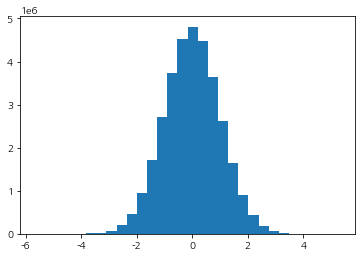

In [32]:
plt.hist(X.flatten(), bins=30)
plt.show()

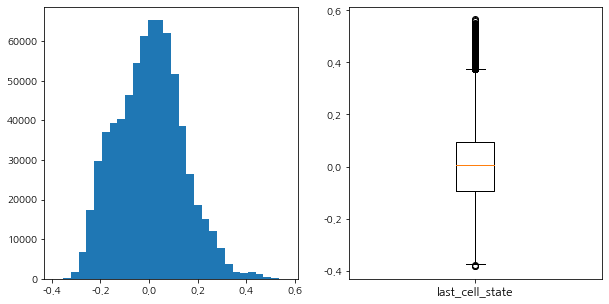

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.hist(last_cell.numpy().flatten(), bins=30)
ax2.boxplot(last_cell.numpy().flatten())
ax2.set_xticklabels(['last_cell_state'],fontsize=12)
plt.show()

In [34]:
ki = lstm.cell.kernel[:, :hidden_states]
kf = lstm.cell.kernel[:, hidden_states:2*hidden_states]
kc = lstm.cell.kernel[:, 2*hidden_states:3*hidden_states]
ko = lstm.cell.kernel[:, 3*hidden_states:]

ri = lstm.cell.recurrent_kernel[:, :hidden_states]
rf = lstm.cell.recurrent_kernel[:, hidden_states:2*hidden_states]
rc = lstm.cell.recurrent_kernel[:, 2*hidden_states:3*hidden_states]
ro = lstm.cell.recurrent_kernel[:, 3*hidden_states:]

bi = lstm.cell.bias[:hidden_states]
bf = lstm.cell.bias[hidden_states:2*hidden_states]
bc = lstm.cell.bias[2*hidden_states:3*hidden_states]
bo = lstm.cell.bias[3*hidden_states:]

In [35]:
for t in range(max_len):
    if t>0: htt = ht # hidden_state[:,t-1,:]
    else: htt = tf.zeros((n_samples, hidden_states))
    X_tf_ = X_tf[:,t,:]

    it = sigmoid(tf.matmul(X_tf_, ki) + tf.matmul(htt, ri) + bi)
    ft = sigmoid(tf.matmul(X_tf_, kf) + tf.matmul(htt, rf) + bf)

    if t==0: ctt = tf.zeros(ft.shape)
    else: ctt = copy.deepcopy(ct)

    ct = ft*ctt + it*(tanh(tf.matmul(X_tf_, kc) + tf.matmul(htt, rc) + bc))
    ot = sigmoid(tf.matmul(X_tf_, ko) + tf.matmul(htt, ro) + bo)
    ht = tanh(ct) * ot
    
    print('t={}'.format(str(t).zfill(2)), end=', ')
    print('validation - calculating hidden state:', np.allclose(hidden_state[:,t,:], ht, ), (hidden_state[:,t,:]- ht).numpy().mean())
    if t==max_len-1:
        print('validation - calculating cell state:', np.allclose(last_cell, ct, ))

t=00, validation - calculating hidden state: True 0.0
t=01, validation - calculating hidden state: True 0.0
t=02, validation - calculating hidden state: True 0.0
t=03, validation - calculating hidden state: True 0.0
t=04, validation - calculating hidden state: True 0.0
t=05, validation - calculating hidden state: True 0.0
t=06, validation - calculating hidden state: True 0.0
t=07, validation - calculating hidden state: True 0.0
t=08, validation - calculating hidden state: True 0.0
t=09, validation - calculating hidden state: True 0.0
t=10, validation - calculating hidden state: True 0.0
t=11, validation - calculating hidden state: True 0.0
t=12, validation - calculating hidden state: True 0.0
t=13, validation - calculating hidden state: True 0.0
t=14, validation - calculating hidden state: True 0.0
t=15, validation - calculating hidden state: True 0.0
t=16, validation - calculating hidden state: True 0.0
t=17, validation - calculating hidden state: True 0.0
t=18, validation - calculati